# Classification of Epileptical Seizures from EEG signals using Deep Learning


## Importing the necessary libraries

In [1]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Activation , LSTM , Dropout , AveragePooling3D
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Data Preprocessing

Importing Data using pandas into a dataframe
and then converting it into a numpy array which is easier to work with.

In [2]:
df=pd.read_csv('datasets/data.csv')
df.head()
X=df.values[:,1:-1]

## Splitting the data into training and testing sets

Using train_test_split() from the Scikit Learn library we split the data into training and testing sets with a test size of 20%

In [3]:
y=np.array(df['y'])
Y=np_utils.to_categorical(y)
Y.shape
# Splitting dataset into traning and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

In [4]:
X_train = X_train.reshape(-1,178,1)
X_test = X_test.reshape(-1,178,1)
print(X_train.shape)
print(X_test.shape)

(9200, 178, 1)
(2300, 178, 1)


178 diamentional vectors with 11500 samples split into
9200 for Training and 2300 for Testing

##  Intuition of the Epileptical Signal In the Dataset 

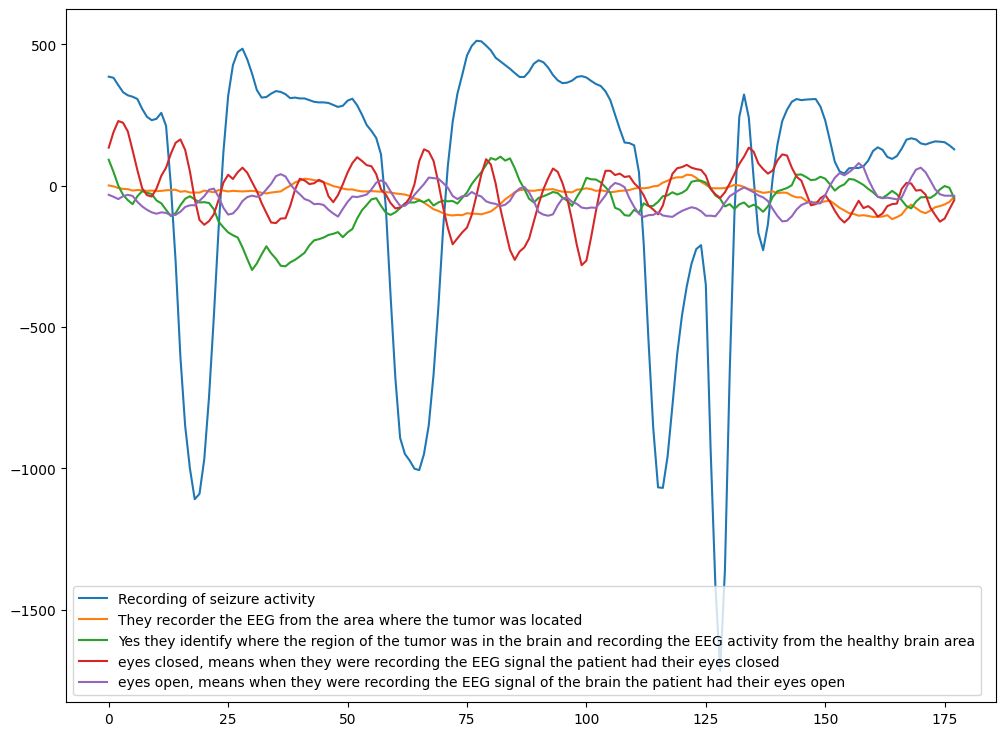

In [5]:
plt.figure(figsize=(12,9))
plt.plot(X[1,:],label='Recording of seizure activity')
plt.plot(X[7,:],label='They recorder the EEG from the area where the tumor was located')
plt.plot(X[12,:],label='Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area')
plt.plot(X[0,:],label='eyes closed, means when they were recording the EEG signal the patient had their eyes closed')
plt.plot(X[2,:],label='eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open')
plt.legend()
plt.show()

## Creating LSTM Neural Network For the Classification 

In [6]:
# Setting parameters for model

model = Sequential()
model.add(LSTM(56, input_shape=(45,1), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(56))
model.add(Dropout(0.3))
model.add(Dense(20))
model.add(Activation('tanh'))
model.add(Dense(5))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 45, 56)            12992     
                                                                 
 dropout (Dropout)           (None, 45, 56)            0         
                                                                 
 lstm_1 (LSTM)               (None, 56)                25312     
                                                                 
 dropout_1 (Dropout)         (None, 56)                0         
                                                                 
 dense (Dense)               (None, 20)                1140      
                                                                 
 activation (Activation)     (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1

In [7]:
# Compile the model with loss function, optimizer and metrics
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
# Train the model
hist = model.fit(
    ((X_train[:, ::4] - X_train.mean()) / X_train.std()).astype(np.float32),
    Y_train[:, 1:].astype(np.float32),
    validation_data=(((X_test[:, ::4] - X_test.mean()) / X_test.std()).astype(np.float32), Y_test[:, 1:].astype(np.float32)),
    epochs=50,
    batch_size=15,
    shuffle=False,
)

Epoch 1/50
614/614 [==============================] - 37s 48ms/step - loss: 0.4174 - accuracy: 0.3897 - val_loss: 0.3855 - val_accuracy: 0.4561
Epoch 2/50
614/614 [==============================] - 28s 45ms/step - loss: 0.3796 - accuracy: 0.4477 - val_loss: 0.3737 - val_accuracy: 0.4796
Epoch 3/50
614/614 [==============================] - 26s 42ms/step - loss: 0.3594 - accuracy: 0.5030 - val_loss: 0.3235 - val_accuracy: 0.5791
Epoch 4/50
614/614 [==============================] - 25s 40ms/step - loss: 0.3017 - accuracy: 0.6010 - val_loss: 0.2685 - val_accuracy: 0.6622
Epoch 5/50
614/614 [==============================] - 25s 41ms/step - loss: 0.2706 - accuracy: 0.6443 - val_loss: 0.2507 - val_accuracy: 0.6657
Epoch 6/50
614/614 [==============================] - 26s 42ms/step - loss: 0.2504 - accuracy: 0.6624 - val_loss: 0.2405 - val_accuracy: 0.6835
Epoch 7/50
614/614 [==============================] - 27s 43ms/step - loss: 0.2422 - accuracy: 0.6750 - val_loss: 0.2362 - val_accuracy:

## Saving The Trained Model

The model is saved in the .h5 format which is the Hierarchical Data Format. It is a file format for storing scientific data. It is most commonly used for storing multidimensional arrays of data. Which is later converted into a tflite model for lighter and faster inference on low power devices.

In [9]:
model.save('models/Epilepsy.h5')

In [10]:
model=tf.keras.models.load_model('models/Epilepsy.h5')
# Create the TFLiteConverter object
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Specify supported ops and disable experimental lower tensor list ops
tflite_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_converter._experimental_lower_tensor_list_ops = False

# Convert the model to TensorFlow Lite format
tflite_model = tflite_converter.convert()

# Save the converted model
open("models/Epilepsy.tflite", "wb").write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpqsaurwm4\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpqsaurwm4\assets


176628

## Visualisations

Graph Between Training Loss and Training Accuracy

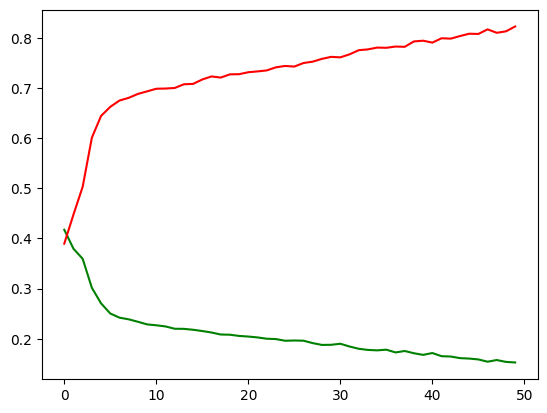

In [11]:
# Loss vs Accuracy is plotted
plt.figure(0)
plt.plot(hist.history['loss'],'g')
plt.plot(hist.history['accuracy'],'r')
plt.show()

Graph Between Validation Loss Function and Validation Accuracy

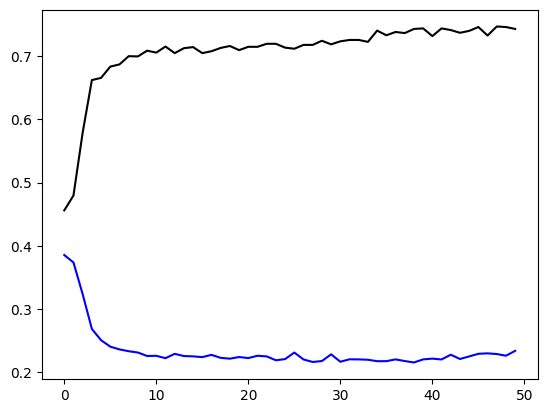

In [12]:
# Value loss and Value accuracy is plotted
plt.figure(0)
plt.plot(hist.history['val_loss'],'b')
plt.plot(hist.history['val_accuracy'],'black')
plt.show()
